In [1]:
import librosa
import soundfile as sf
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


import soundfile as sf

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns 

import librosa
import librosa.display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

2023-07-30 23:04:04.402910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#creating 6 second sengments of audio samples used previously to create more data

In [2]:
def trim_audio_files(input_folder, output_folder):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each genre subfolder
    genres = os.listdir(input_folder)
    for genre in genres:
        genre_folder = os.path.join(input_folder, genre)

        # Check if it's a directory
        if not os.path.isdir(genre_folder):
            continue

        # subfolder for the genre in the output folder
        genre_output_folder = os.path.join(output_folder, genre)
        if not os.path.exists(genre_output_folder):
            os.makedirs(genre_output_folder)

        # Looping through each audio file in the genre folder that ends with .wav
        audio_files = [f for f in os.listdir(genre_folder) if f.endswith(".wav") and not f.startswith(".")]
        for audio_file in audio_files:
            input_file_path = os.path.join(genre_folder, audio_file)

            # Loading audio file
            audio, sr = librosa.load(input_file_path, sr=None)

            # creating 6 second clips/segments of audio
            segment_duration = 6  
            num_segments = len(audio) // (sr * segment_duration)

            # Looping through the audio and creating new files for each segment
            for i in range(num_segments):
                start_sample = i * sr * segment_duration
                end_sample = (i + 1) * sr * segment_duration

                # Extract the segment
                segment = audio[start_sample:end_sample]

                output_file = os.path.join(genre_output_folder, f"{audio_file[:-4]}_segment_{i + 1}.wav")

                # Save the segment as a new WAV file using soundfile
                sf.write(output_file, segment, sr)

    print(f"Trimmed segments for all genres created and saved in {output_folder}")

In [3]:
#input_folder = "/Users/kellyjara/Desktop/Test Data/genres_original"
#output_folder = "/Users/kellyjara/Desktop/Test Data/genres_trimmed"
#trim_audio_files(input_folder, output_folder)

In [4]:
def melspec_features(audio_path, sr=22050, n_mels=64, hop_length=400, n_frames=1, n_fft=1024):

    #loading audio file
    y, sr = librosa.load(audio_path)  
    #creating melspec feature
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft = n_fft,
                                          hop_length = hop_length, n_mels = n_mels)
    #normalizing mel spectrogram
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    #pad/truncating to ensure all audio samples have the same length prior to running through the model
    mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max(0, n_frames - mel_spectrogram.shape[1]))), 
                             mode='constant')
    mel_spectrogram = mel_spectrogram[:, :n_frames]
    
    return mel_spectrogram

In [5]:
def load_audio_files(data_dir, genres):
    #creating empty list
    all_mel_spectrograms = []
    all_labels = []
    
    for genre_index, genre in enumerate(genres):
        genre_dir = os.path.join(directory, genre)
        audio_files = os.listdir(genre_dir)

        for audio_file in audio_files:
            audio_path = os.path.join(genre_dir, audio_file)
            #looping through files making sure it ends with .wav (have hidden files within the directory)
            if os.path.isfile(audio_path) and audio_file.lower().endswith(('.wav')):
                mel_spectrogram = melspec_features(audio_path)

                all_mel_spectrograms.append(mel_spectrogram)
                all_labels.append(genre_index)

    all_mel_spectrograms = np.array(all_mel_spectrograms)
    all_labels = np.array(all_labels)

    return all_mel_spectrograms, all_labels

In [6]:
directory = '/Users/kellyjara/Desktop/Test Data/genres_trimmed'
genres = ['blues', 'classical', 'country', 'disco','hiphop', 'jazz','metal', 'pop', 'reggae', 'rock']

all_mel_spectrograms, all_labels = load_audio_files(directory, genres)

In [7]:
#reshapping to create df with info
reshaped_mel_spectrograms = [mel_spectrogram.ravel() for mel_spectrogram in all_mel_spectrograms]

spectrogram_series = [pd.Series(mel_spectrogram) for mel_spectrogram in reshaped_mel_spectrograms]

df = pd.concat([pd.DataFrame(spectrogram_series), pd.Series(all_labels, name='label')], axis=1)

In [8]:
df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,-14.251838,-13.122309,-17.378595,-19.016870,-19.089672,-17.880081,-23.351181,-32.613007,-34.962963,-30.712912,...,-42.086105,-43.506081,-39.105614,-39.922958,-40.942955,-42.006210,-42.275425,-41.509205,-44.791512,0
1,-12.428816,-17.256380,-18.799641,-19.021170,-19.608223,-22.834064,-16.038242,-8.856348,-7.850418,-16.071945,...,-46.514069,-48.036354,-49.952156,-51.625275,-53.129398,-52.573864,-55.373749,-53.135368,-55.536079,0
2,-7.222175,-7.465009,-9.467773,-15.350006,-24.655840,-22.813179,-20.164675,-23.900408,-38.443485,-31.208973,...,-53.659267,-54.747837,-60.761158,-61.606316,-57.550751,-58.037479,-60.899445,-59.296982,-62.759602,0
3,-13.839224,-13.039390,-18.652845,-29.813875,-20.888809,-16.828560,-19.395489,-26.127188,-29.592663,-31.395107,...,-54.769577,-53.704842,-53.416397,-53.807476,-55.259468,-54.551189,-56.562866,-57.151756,-60.965576,0
4,-19.986414,-22.005198,-18.739420,-18.591976,-15.725191,-22.208080,-28.902262,-24.956005,-20.785997,-16.100275,...,-43.896725,-46.755569,-52.995403,-55.550240,-53.113583,-56.862617,-61.081062,-61.500278,-61.719170,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6982,-13.378391,-10.708499,-15.370485,-11.596584,-12.495448,-16.466030,-21.985592,-14.784528,-16.598976,-19.682400,...,-45.647564,-47.738373,-49.398979,-49.625301,-46.350544,-46.979458,-45.527466,-46.959904,-45.310547,9
6983,-18.467232,-16.839695,-13.625200,-16.526506,-24.118832,-33.124847,-34.478302,-30.374168,-32.384529,-37.375149,...,-45.114441,-44.281456,-41.380348,-45.138222,-52.663433,-55.906128,-61.424278,-72.231430,-77.239876,9
6984,-6.984684,-9.222915,-11.196207,-10.992528,-15.453659,-21.275131,-18.631214,-18.427641,-27.493244,-25.264580,...,-46.526024,-49.678352,-49.137489,-52.539230,-52.193123,-50.913567,-54.511108,-56.806702,-59.181122,9
6985,-17.453598,-16.001034,-19.410364,-22.572104,-24.987122,-31.891487,-37.920929,-25.246262,-18.473724,-22.237137,...,-48.276230,-53.166828,-50.687626,-51.501633,-49.681099,-48.311752,-52.811054,-56.392250,-57.144054,9


In [9]:
X = df.drop('label', axis=1).values
y = df['label'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .20)

In [11]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(np.array(X_train, dtype = float))
X_val_sc = scaler.transform(np.array(X_val, dtype = float))
X_test_sc = scaler.transform(np.array(X_test, dtype = float))

In [12]:
X_train_reshaped = X_train_sc.reshape((X_train_sc.shape[0], 1, X_train_sc.shape[1]))
X_test_reshaped = X_test_sc.reshape(X_test_sc.shape[0], 1, X_test_sc.shape[1])
X_val_reshaped = X_val_sc.reshape(X_val_sc.shape[0], 1, X_val_sc.shape[1])

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, input_shape=(X_train_sc.shape[1], 1), return_sequences=True),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(units=32, activation='relu'),  
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(units=10, activation='softmax')
])

In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_sc, y_train, epochs=50, batch_size=225, validation_data=(X_val_sc, y_val))

Epoch 1/50
19/19 [==============================] - 22s 752ms/step - loss: 2.2331 - accuracy: 0.1622 - val_loss: 2.1907 - val_accuracy: 0.1756
Epoch 2/50
19/19 [==============================] - 14s 740ms/step - loss: 2.1648 - accuracy: 0.1913 - val_loss: 2.1166 - val_accuracy: 0.2080
Epoch 3/50
19/19 [==============================] - 14s 713ms/step - loss: 2.1207 - accuracy: 0.2197 - val_loss: 2.0993 - val_accuracy: 0.2166
Epoch 4/50
19/19 [==============================] - 13s 692ms/step - loss: 2.1013 - accuracy: 0.2302 - val_loss: 2.0742 - val_accuracy: 0.2319
Epoch 5/50
19/19 [==============================] - 12s 646ms/step - loss: 2.0848 - accuracy: 0.2326 - val_loss: 2.0628 - val_accuracy: 0.2271
Epoch 6/50
19/19 [==============================] - 12s 643ms/step - loss: 2.0763 - accuracy: 0.2531 - val_loss: 2.0500 - val_accuracy: 0.2452
Epoch 7/50
19/19 [==============================] - 11s 589ms/step - loss: 2.0452 - accuracy: 0.2567 - val_loss: 2.0290 - val_accuracy: 0.2357

In [15]:
loss, accuracy = model.evaluate(X_train_sc, y_train)
print(f":loss: {loss}, accuracy: {accuracy}")

131/131 [==============================] - 4s 31ms/step - loss: 1.7386 - accuracy: 0.3662
:loss: 1.7385785579681396, accuracy: 0.366173654794693


In [16]:
test_loss = model.evaluate(X_val_sc, y_val)
print(f'Test Loss: {test_loss}')

33/33 [==============================] - 1s 30ms/step - loss: 1.8991 - accuracy: 0.3025
Test Loss: [1.8991410732269287, 0.30248090624809265]


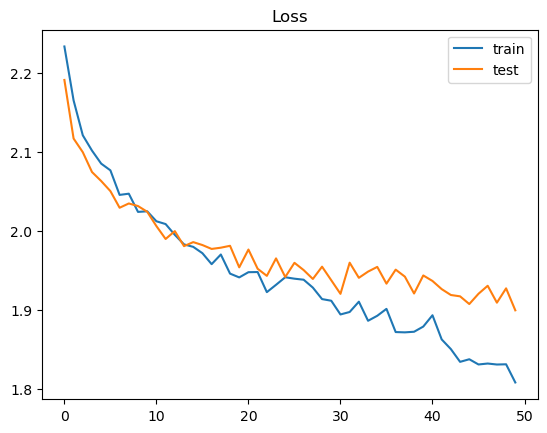

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

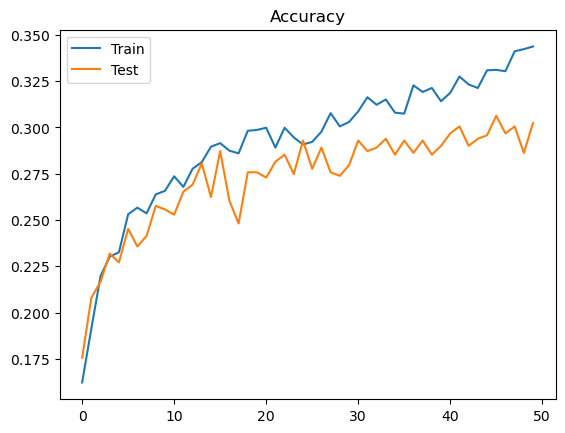

In [18]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = "Test")
plt.legend()
plt.show()

In [19]:
### rnn model with regularization 
from tensorflow.keras.regularizers import L2

reg_lambda = 0.01  # Regularization strength

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, input_shape=(X_train_sc.shape[1], 1), return_sequences=True,
                         kernel_regularizer=L2(reg_lambda)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=64, kernel_regularizer=L2(reg_lambda)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=L2(reg_lambda)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=10, activation='softmax', kernel_regularizer=L2(reg_lambda))
])

In [20]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_sc, y_train, epochs=50, batch_size=225, validation_data=(X_val_sc, y_val))

Epoch 1/50
19/19 [==============================] - 13s 446ms/step - loss: 4.1836 - accuracy: 0.1560 - val_loss: 3.7809 - val_accuracy: 0.1718
Epoch 2/50
19/19 [==============================] - 7s 395ms/step - loss: 3.4968 - accuracy: 0.1854 - val_loss: 3.2190 - val_accuracy: 0.1899
Epoch 3/50
19/19 [==============================] - 7s 392ms/step - loss: 3.0430 - accuracy: 0.1944 - val_loss: 2.8701 - val_accuracy: 0.2109
Epoch 4/50
19/19 [==============================] - 7s 392ms/step - loss: 2.7458 - accuracy: 0.2252 - val_loss: 2.6293 - val_accuracy: 0.2261
Epoch 5/50
19/19 [==============================] - 7s 394ms/step - loss: 2.5663 - accuracy: 0.2276 - val_loss: 2.4961 - val_accuracy: 0.2137
Epoch 6/50
19/19 [==============================] - 7s 392ms/step - loss: 2.4443 - accuracy: 0.2347 - val_loss: 2.3973 - val_accuracy: 0.2252
Epoch 7/50
19/19 [==============================] - 7s 393ms/step - loss: 2.3457 - accuracy: 0.2524 - val_loss: 2.3469 - val_accuracy: 0.2176
Epoch

In [21]:
loss, accuracy = model.evaluate(X_train_sc, y_train)
print(f":loss: {loss}, accuracy: {accuracy}")
test_loss = model.evaluate(X_val_sc, y_val)
print(f'Test Loss: {test_loss}')

131/131 [==============================] - 5s 41ms/step - loss: 1.9788 - accuracy: 0.3261
:loss: 1.978839635848999, accuracy: 0.3260973393917084
33/33 [==============================] - 1s 40ms/step - loss: 2.0619 - accuracy: 0.2748
Test Loss: [2.061898946762085, 0.2748091518878937]


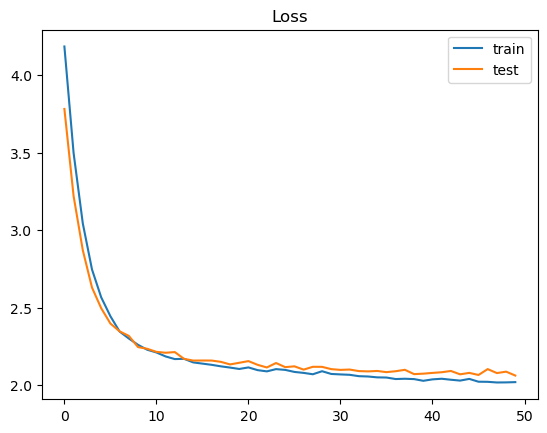

In [22]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

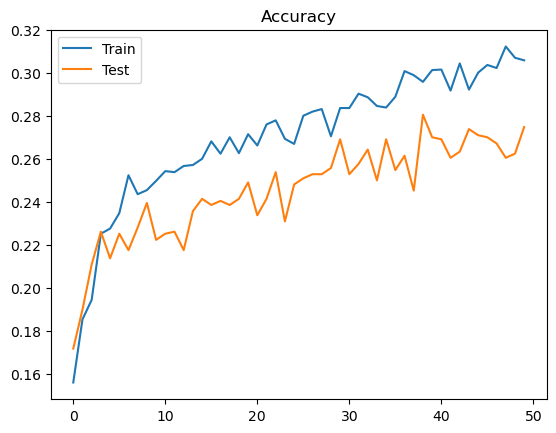

In [23]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = "Test")
plt.legend()
plt.show()

In [40]:
reg_lambda = 0.01

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], 1), return_sequences=True,
                         kernel_regularizer=L2(reg_lambda)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=64, kernel_regularizer=L2(reg_lambda)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=32, activation='sigmoid', kernel_regularizer=L2(reg_lambda)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=10, activation='softmax', kernel_regularizer=L2(reg_lambda))
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_sc, y_train, epochs=150, batch_size=300, validation_data=(X_val_sc, y_val))

Epoch 1/150
14/14 [==============================] - 12s 575ms/step - loss: 4.4605 - accuracy: 0.1119 - val_loss: 4.0561 - val_accuracy: 0.1489
Epoch 2/150
14/14 [==============================] - 7s 498ms/step - loss: 3.8067 - accuracy: 0.1374 - val_loss: 3.5176 - val_accuracy: 0.1632
Epoch 3/150
14/14 [==============================] - 7s 504ms/step - loss: 3.3765 - accuracy: 0.1696 - val_loss: 3.1615 - val_accuracy: 0.1889
Epoch 4/150
14/14 [==============================] - 7s 498ms/step - loss: 3.0618 - accuracy: 0.1715 - val_loss: 2.9146 - val_accuracy: 0.2080
Epoch 5/150
14/14 [==============================] - 7s 504ms/step - loss: 2.8369 - accuracy: 0.1927 - val_loss: 2.7288 - val_accuracy: 0.2013
Epoch 6/150
14/14 [==============================] - 7s 506ms/step - loss: 2.6730 - accuracy: 0.1982 - val_loss: 2.6049 - val_accuracy: 0.2195
Epoch 7/150
14/14 [==============================] - 9s 643ms/step - loss: 2.5555 - accuracy: 0.2123 - val_loss: 2.5066 - val_accuracy: 0.226

Epoch 58/150
14/14 [==============================] - 7s 530ms/step - loss: 2.1318 - accuracy: 0.2617 - val_loss: 2.1578 - val_accuracy: 0.2490
Epoch 59/150
14/14 [==============================] - 9s 687ms/step - loss: 2.1277 - accuracy: 0.2672 - val_loss: 2.1794 - val_accuracy: 0.2385
Epoch 60/150
14/14 [==============================] - 10s 686ms/step - loss: 2.1311 - accuracy: 0.2700 - val_loss: 2.1770 - val_accuracy: 0.2357
Epoch 61/150
14/14 [==============================] - 12s 880ms/step - loss: 2.1234 - accuracy: 0.2765 - val_loss: 2.1626 - val_accuracy: 0.2328
Epoch 62/150
14/14 [==============================] - 17s 1s/step - loss: 2.1401 - accuracy: 0.2638 - val_loss: 2.1612 - val_accuracy: 0.2538
Epoch 63/150
14/14 [==============================] - 15s 1s/step - loss: 2.1314 - accuracy: 0.2631 - val_loss: 2.1647 - val_accuracy: 0.2462
Epoch 64/150
14/14 [==============================] - 9s 624ms/step - loss: 2.1262 - accuracy: 0.2615 - val_loss: 2.1750 - val_accuracy: 0

Epoch 115/150
14/14 [==============================] - 8s 550ms/step - loss: 2.0755 - accuracy: 0.2958 - val_loss: 2.1599 - val_accuracy: 0.2557
Epoch 116/150
14/14 [==============================] - 8s 564ms/step - loss: 2.0851 - accuracy: 0.2972 - val_loss: 2.1520 - val_accuracy: 0.2634
Epoch 117/150
14/14 [==============================] - 8s 573ms/step - loss: 2.0778 - accuracy: 0.2932 - val_loss: 2.1654 - val_accuracy: 0.2500
Epoch 118/150
14/14 [==============================] - 8s 586ms/step - loss: 2.0855 - accuracy: 0.2946 - val_loss: 2.1546 - val_accuracy: 0.2405
Epoch 119/150
14/14 [==============================] - 8s 594ms/step - loss: 2.0838 - accuracy: 0.2889 - val_loss: 2.1449 - val_accuracy: 0.2490
Epoch 120/150
14/14 [==============================] - 8s 604ms/step - loss: 2.0836 - accuracy: 0.2996 - val_loss: 2.1634 - val_accuracy: 0.2519
Epoch 121/150
14/14 [==============================] - 8s 539ms/step - loss: 2.0782 - accuracy: 0.2958 - val_loss: 2.1531 - val_ac

In [37]:
loss, accuracy = model.evaluate(X_train, y_train)
print(f":loss: {loss}, accuracy: {accuracy}")
test_loss = model.evaluate(X_val, y_val)
print(f'Test Loss: {test_loss}')

131/131 [==============================] - 4s 32ms/step - loss: 1.9391 - accuracy: 0.3547
:loss: 1.9391006231307983, accuracy: 0.3547232747077942
33/33 [==============================] - 1s 31ms/step - loss: 2.1368 - accuracy: 0.2758
Test Loss: [2.1367955207824707, 0.2757633626461029]


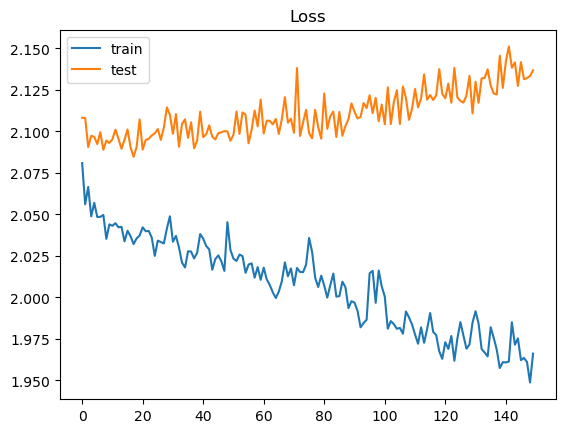

In [38]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

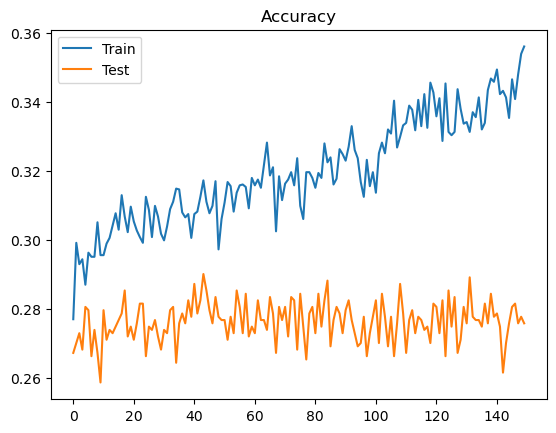

In [39]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = "Test")
plt.legend()
plt.show()

In [29]:
time_steps = 1  
X_train_sc_reshaped = X_train_sc.reshape(X_train_sc.shape[0], time_steps, X_train_sc.shape[1])

model = keras.Sequential([
    layers.Bidirectional(layers.LSTM(units=128, activation='relu', return_sequences=True), input_shape=(time_steps, X_train_sc.shape[1])),
    layers.Bidirectional(layers.LSTM(units=64, activation='Softmax')),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with validation data
history = model.fit(X_train_sc_reshaped, y_train, epochs=20, batch_size=225, verbose=1, validation_data=(X_val_reshaped, y_val))

Epoch 1/20
19/19 [==============================] - 12s 100ms/step - loss: 0.0000e+00 - accuracy: 0.1004 - val_loss: 0.0000e+00 - val_accuracy: 0.0983
Epoch 2/20
19/19 [==============================] - 1s 28ms/step - loss: 0.0000e+00 - accuracy: 0.1004 - val_loss: 0.0000e+00 - val_accuracy: 0.0983
Epoch 3/20
19/19 [==============================] - 1s 31ms/step - loss: 0.0000e+00 - accuracy: 0.1004 - val_loss: 0.0000e+00 - val_accuracy: 0.0983
Epoch 4/20
19/19 [==============================] - 1s 32ms/step - loss: 0.0000e+00 - accuracy: 0.1004 - val_loss: 0.0000e+00 - val_accuracy: 0.0983
Epoch 5/20
19/19 [==============================] - 1s 33ms/step - loss: 0.0000e+00 - accuracy: 0.1004 - val_loss: 0.0000e+00 - val_accuracy: 0.0983
Epoch 6/20
19/19 [==============================] - 1s 33ms/step - loss: 0.0000e+00 - accuracy: 0.1004 - val_loss: 0.0000e+00 - val_accuracy: 0.0983
Epoch 7/20
19/19 [==============================] - 1s 31ms/step - loss: 0.0000e+00 - accuracy: 0.1004 -

In [30]:
loss, accuracy = model.evaluate(X_train_sc_reshaped, y_train)
print(f":loss: {loss}, accuracy: {accuracy}")
test_loss = model.evaluate(X_val_reshaped, y_val)
print(f'Test Loss: {test_loss}')

131/131 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.1004
:loss: 0.0, accuracy: 0.10042938590049744
33/33 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.0983
Test Loss: [0.0, 0.09828244149684906]


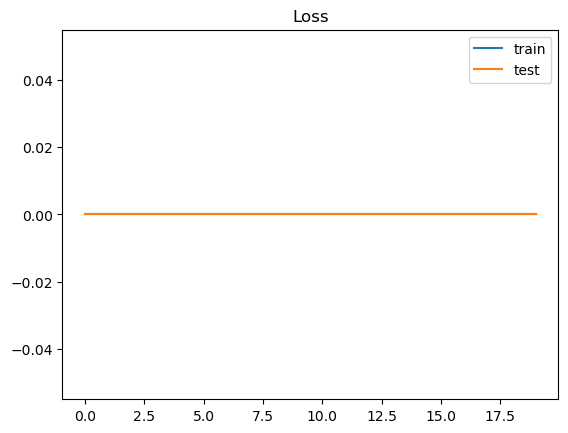

In [31]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

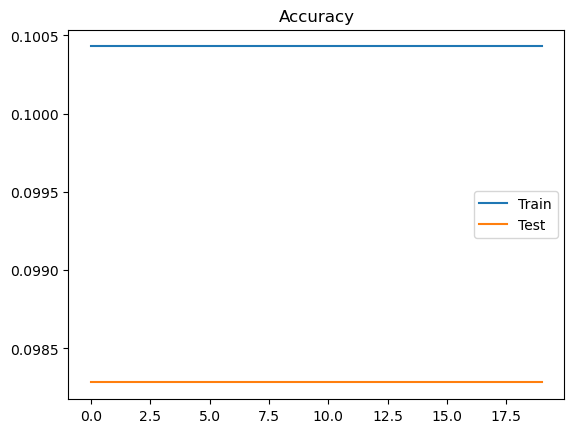

In [32]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = "Test")
plt.legend()
plt.show()